In [19]:
import pandas as pd
import re

from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

import datasetreader

import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/nqtuan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/nqtuan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
df_train = datasetreader.readTrain()
df_train.head()
df_test = datasetreader.readTest()

In [21]:
df_train.groupby('Sentiment').count()

,PhraseId,SentenceId,Phrase
Sentiment,,,
0,7072,7072,7072
1,27273,27273,27273
2,79582,79582,79582
3,32927,32927,32927
4,9206,9206,9206


In [42]:
lemmatizer = WordNetLemmatizer()

def clean_sentences(df):
    reviews = []

    for sent in tqdm(df['Phrase']):
        
        #remove html content
        review_text = BeautifulSoup(sent).get_text()
        
        #remove non-alphabetic characters
        review_text = re.sub("[^a-zA-Z]"," ", review_text)
    
        #tokenize the sentences
        words = word_tokenize(review_text.lower())
    
        #lemmatize each word to its lemma
        lemma_words = [lemmatizer.lemmatize(i) for i in words]
    
        reviews.append(lemma_words)

    return(reviews)

#cleaned reviews for both train and test set retrieved
train_sentences = clean_sentences(df_train)
test_sentences = clean_sentences(df_test)
print(len(train_sentences))
print(len(test_sentences))

  0%|          | 0/156060 [00:00<?, ?it/s]/home/nqtuan/.local/lib/python3.6/site-packages/bs4/__init__.py:272: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
100%|██████████| 66292/66292 [00:11<00:00, 6018.80it/s]

156060
66292


In [5]:
# convert to one-hot vector
target = df_train.Sentiment.values
y_target = to_categorical(target)
num_classes = y_target.shape[1]

X_train, X_val, y_train, y_val = train_test_split(train_sentences, y_target, test_size=0.2, stratify=y_target)

In [6]:
#length of the list of unique_words gives the no of unique words
unique_words = set()
len_max = 0

for sent in tqdm(X_train):
    
    unique_words.update(sent)
    
    if(len_max < len(sent)):
        len_max = len(sent)

print(len(list(unique_words)))
print(len_max)

100%|██████████| 124848/124848 [00:00<00:00, 899753.89it/s]

13738
48


In [7]:
print(len(X_train), X_train[0], X_train[1], X_train[-1])

124848 ['better', 'focused', 'than', 'the', 'incomprehensible', 'anne', 'rice', 'novel'] ['grizzled'] ['mixed', 'up', 'together', 'like', 'a', 'term', 'paper']


In [8]:
tokenizer = Tokenizer(num_words=len(list(unique_words)))
tokenizer.fit_on_texts(list(X_train))
X_train = tokenizer.texts_to_sequences(X_train)
X_val = tokenizer.texts_to_sequences(X_val)
X_test = tokenizer.texts_to_sequences(test_sentences)

#padding done to equalize the lengths of all input reviews. LSTM networks needs all inputs to be same length.
#Therefore reviews lesser than max length will be made equal using extra zeros at end. This is padding.
X_train = sequence.pad_sequences(X_train, maxlen=len_max)
X_val = sequence.pad_sequences(X_val, maxlen=len_max)
X_test = sequence.pad_sequences(X_test, maxlen=len_max)
print(X_train.shape, X_val.shape, X_test.shape)

(124848, 48) (31212, 48) (66292, 48)


In [9]:
print(X_train.shape, X_train[0], X_train[1], X_train[-1])

(124848, 48) [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0  127 3227
   32    1 3650 1554 2523  588] [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0 10869] [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 1177
   45  285   34    2  696 1215]


In [10]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM
from keras.optimizers import Adam

early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)
callback = [early_stopping]

#Model using Keras LSTM
model=Sequential()
model.add(Embedding(len(list(unique_words)),300,input_length=len_max))
model.add(LSTM(128,dropout=0.5, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.005),metrics=['accuracy'])
model.summary()


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 48, 300)           4121400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 48, 128)           219648    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               6500      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)      

In [11]:
#This is done for learning purpose only. One can play around with different hyper parameters combinations
#and try increase the accuracy even more. For example, a different learning rate, an extra dense layer 
# before output layer, etc. Cross validation could be used to evaluate the model and grid search 
# further to find unique combination of parameters that give maximum accuracy. This model has a validation
#accuracy of around 66.5%
history=model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=6, batch_size=256, verbose=1, callbacks=callback)

Instructions for updating:
Use tf.cast instead.
Train on 124848 samples, validate on 31212 samples
Epoch 1/6
124848/124848 [==============================] - 154s 1ms/step - loss: 1.0095 - acc: 0.5937 - val_loss: 0.8526 - val_acc: 0.6463
Epoch 2/6
124848/124848 [==============================] - 153s 1ms/step - loss: 0.8093 - acc: 0.6669 - val_loss: 0.8160 - val_acc: 0.6658
Epoch 3/6
124848/124848 [==============================] - 144s 1ms/step - loss: 0.7414 - acc: 0.6944 - val_loss: 0.8107 - val_acc: 0.6690
Epoch 4/6
124848/124848 [==============================] - 139s 1ms/step - loss: 0.6982 - acc: 0.7085 - val_loss: 0.8318 - val_acc: 0.6657
Epoch 5/6
124848/124848 [==============================] - 142s 1ms/step - loss: 0.6730 - acc: 0.7183 - val_loss: 0.8569 - val_acc: 0.6687


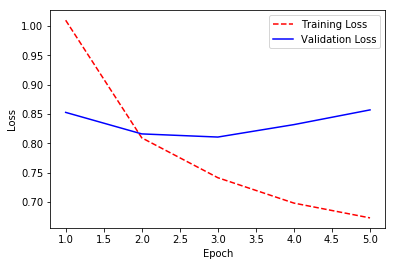

In [18]:
import matplotlib.pyplot as plt

# Create count of the number of epochs
epoch_count = range(1, len(history.history['loss']) + 1)

# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.
#As mentioned before, altering different hyper parameters especially learning rate can have a positive impact
#on accuracy and learning curve.
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [13]:
#make the predictions with trained model and submit the predictions.
y_pred=model.predict_classes(X_test)

sub_file = pd.read_csv('dataset/sampleSubmission.csv',sep=',')


In [14]:
sub_file

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2
5,156066,2
6,156067,2
7,156068,2
8,156069,2
9,156070,2


In [15]:
X_test.shape

(66292, 48)

In [16]:
len(test_sentences)

66292

In [17]:
sub_file.Sentiment=y_pred
sub_file.to_csv('Submission.csv',index=False)